## Import libraries


In [ ]:
import os
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from scipy.stats import linregress
from tqdm.auto import tqdm

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = "Times New Roman"

import warnings

warnings.filterwarnings("ignore")

WORK_DIR = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/"
os.chdir(WORK_DIR)
MAIN_DATA_DIR = "/beegfs/halder/DATA/"
OUT_DIR = os.path.join(WORK_DIR, "output")

In [ ]:
# Parameters
CROP = "winter_barley"

## Read the data


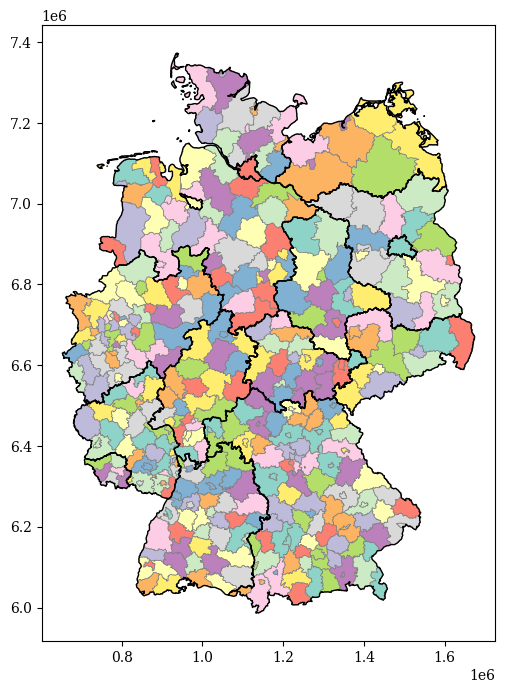

(16, 6) (400, 6)


NUTS_ID  LEVL_CODE CNTR_CODE                NAME_LATN  \
0   DE11B          3        DE        Main-Tauber-Kreis   
1   DE11C          3        DE               Heidenheim   
2   DE11D          3        DE              Ostalbkreis   
3   DE121          3        DE  Baden-Baden, Stadtkreis   
4   DE122          3        DE    Karlsruhe, Stadtkreis   

                 NUTS_NAME                                           geometry  
0        Main-Tauber-Kreis  POLYGON ((1074230.536 6408356.046, 1073820.827...  
1               Heidenheim  MULTIPOLYGON (((1131091.261 6235073.568, 11312...  
2              Ostalbkreis  MULTIPOLYGON (((1141777.678 6284962.486, 11412...  
3  Baden-Baden, Stadtkreis  MULTIPOLYGON (((910859.613 6248068.047, 913127...  
4    Karlsruhe, Stadtkreis  POLYGON ((938225.711 6286986.826, 940668.057 6...

In [85]:
# Read the NUTS1 and NUTS3 shapefile for DE
de_nuts1_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts1_gdf = de_nuts1_gdf[
    de_nuts1_gdf["LEVL_CODE"] == 1
]  # filter only NUT1 level code

de_nuts3_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts3_gdf = de_nuts3_gdf[
    de_nuts3_gdf["LEVL_CODE"] == 3
]  # filter only NUT3 level code

fig, ax = plt.subplots(figsize=(8, 8))
de_nuts3_gdf.plot(
    ax=ax,
    column="NUTS_NAME",
    cmap="Set3",
    edgecolor="grey",
    linewidth=0.5,
    label="NUTS3",
)
de_nuts1_gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1, label="NUTS1")
plt.show()

print(de_nuts1_gdf.shape, de_nuts3_gdf.shape)
de_nuts3_gdf.head()

In [86]:
# Read the yield data
yield_df = pd.read_csv(
    os.path.join(MAIN_DATA_DIR, "DE_Crop_Yield", "DE_Crop_Yield_Master.csv")
)
yield_df.dropna(subset=["value"], inplace=True)  # dropping NaN values
yield_df = yield_df[["nuts_id", "year", "var", "value"]]
yield_df.rename(
    columns={"nuts_id": "NUTS_ID", "var": "crop", "value": "yield"}, inplace=True
)
crop_names = {
    "rye": "winter_rye",
    "wb": "winter_barley",
    "wrape": "winter_rapeseed",
    "ww": "winter_wheat",
    "silage_maize": "silage_maize",
}
yield_df = yield_df[yield_df["crop"].isin(crop_names.keys())]
yield_df["crop"] = yield_df["crop"].replace(crop_names)

print("Name of the crops:", yield_df["crop"].unique())
print(yield_df.shape)
yield_df.head()

Name of the crops: ['winter_rye' 'silage_maize' 'winter_barley' 'winter_rapeseed'
 'winter_wheat']
(74404, 4)


NUTS_ID  year             crop  yield
3   DEF01  1979       winter_rye   4.35
5   DEF01  1979     silage_maize  43.60
7   DEF01  1979    winter_barley   4.52
8   DEF01  1979  winter_rapeseed   2.83
9   DEF01  1979     winter_wheat   5.29

## Analyze the yield data


In [101]:
yield_df_filtered = yield_df[yield_df["crop"] == CROP].reset_index(drop=True)
nuts3_info = de_nuts3_gdf.copy()

output_dir = os.path.join(OUT_DIR, "figures", "yield_eda", CROP)
if os.path.exists(output_dir) != True:
    os.makedirs(output_dir)
    print("Output folder successfully created!")

print(nuts3_info.shape, yield_df_filtered.shape)

(400, 6) (15482, 4)


### Count of Yield Observation per NUTS


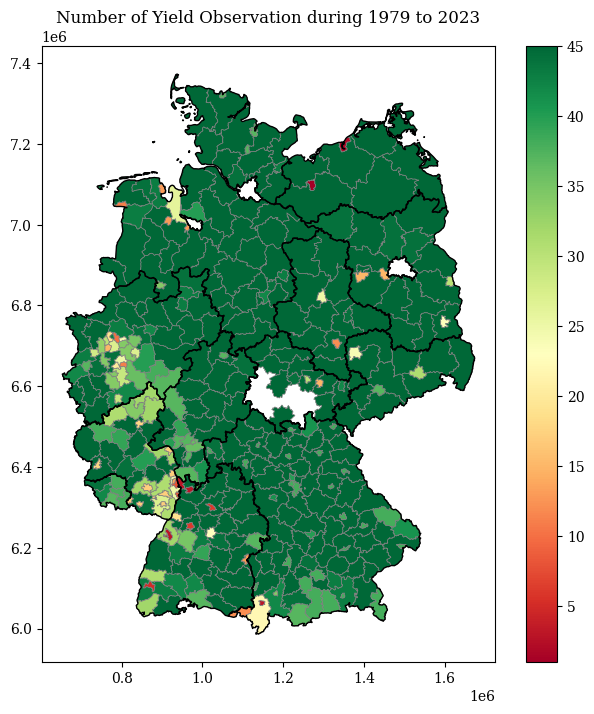

In [ ]:
# Calculate the count of yield observation per nuts
yield_obs_count = yield_df_filtered["NUTS_ID"].value_counts().to_frame().reset_index()
yield_obs_count.rename(columns={"count": f"yield_count"}, inplace=True)
nuts3_info = pd.merge(
    left=nuts3_info, right=yield_obs_count, on=["NUTS_ID"], how="left"
)

fig, ax = plt.subplots(figsize=(8, 8))
nuts3_info.plot(
    ax=ax,
    column="yield_count",
    cmap="RdYlGn",
    edgecolor="grey",
    linewidth=0.5,
    label="Yield Count",
    legend=True,
)
de_nuts1_gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1, label="NUTS1")
plt.title(
    f"Number of Yield Observation during {yield_df_filtered['year'].min()} to {yield_df_filtered['year'].max()}"
)
plt.savefig(
    os.path.join(output_dir, "count_of_yield_observation.png"),
    format="png",
    bbox_inches="tight",
)
plt.show()

### Yield Anomaly and Extremes


Optimizing LOESS frac for 397 districts...


  0%|          | 0/397 [00:00<?, ?it/s]


--- Results ---
Frac 0.20 | RMSE: 0.9822
Frac 0.25 | RMSE: 0.9543
Frac 0.30 | RMSE: 0.9285
Frac 0.35 | RMSE: 0.9106
Frac 0.40 | RMSE: 0.8931
Frac 0.45 | RMSE: 0.8830
Frac 0.50 | RMSE: 0.8723
Frac 0.55 | RMSE: 0.8640
Frac 0.60 | RMSE: 0.8526
Frac 0.65 | RMSE: 0.8457
Frac 0.70 | RMSE: 0.8378
Frac 0.75 | RMSE: 0.8316
Frac 0.80 | RMSE: 0.8272
Frac 0.85 | RMSE: 0.8255


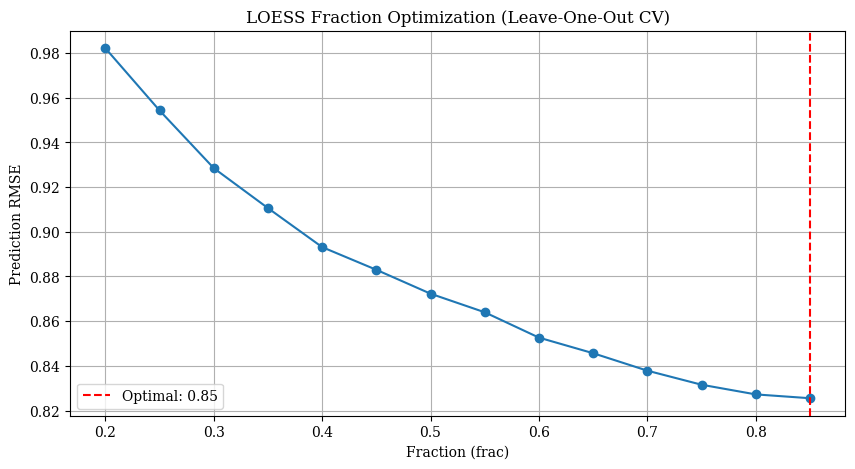


✅ Optimal LOESS Fraction: 0.85


In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


def optimize_loess_frac(df, target_col="yield", id_col="NUTS_ID", year_col="year"):
    """
    Finds the optimal LOESS fraction using Leave-One-Out Cross Validation.
    """
    # Range of fractions to test (from very wiggly 0.1 to very smooth 0.9)
    frac_candidates = np.arange(0.2, 0.9, 0.05)

    district_errors = {f: [] for f in frac_candidates}

    districts = df[id_col].unique()
    print(f"Optimizing LOESS frac for {len(districts)} districts...")

    for nuts_id in tqdm(districts):
        # Get data for one district
        group = df[df[id_col] == nuts_id].sort_values(year_col)

        # We need at least 15 years of data to do meaningful CV
        if len(group) < 15:
            continue

        years = group[year_col].values
        yields = group[target_col].values

        # --- Forward-Chaining CV ---
        # For every year i, we fit on all years strictly before i and predict i
        min_train_size = 15
        for i in range(min_train_size, len(years)):

            # Training = all years strictly before i
            train_years = years[:i]
            train_yields = yields[:i]

            val_year = years[i]
            val_yield = yields[i]

            for f in frac_candidates:
                # Fit LOESS on training set
                # return_sorted=False ensures we match input order if needed,
                # but here we just need the curve
                smoothed = sm.nonparametric.lowess(
                    train_yields, train_years, frac=f, return_sorted=True
                )

                # Interpolate to find the value at the missing year i
                # (LOESS creates points at x values; we linear interpolate between neighbors)
                pred_yield = np.interp(val_year, smoothed[:, 0], smoothed[:, 1])

                # Calculate Squared Error
                error = (val_yield - pred_yield) ** 2
                district_errors[f].append(error)

    # --- Aggregation ---
    print("\n--- Results ---")
    best_frac = None
    min_rmse = float("inf")

    frac_results = []
    rmse_results = []

    for f in frac_candidates:
        rmse = np.sqrt(np.mean(district_errors[f]))
        frac_results.append(f)
        rmse_results.append(rmse)
        print(f"Frac {f:.2f} | RMSE: {rmse:.4f}")

        if rmse < min_rmse:
            min_rmse = rmse
            best_frac = f

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(frac_results, rmse_results, marker="o")
    plt.axvline(best_frac, color="r", linestyle="--", label=f"Optimal: {best_frac:.2f}")
    plt.title("LOESS Fraction Optimization (Leave-One-Out CV)")
    plt.xlabel("Fraction (frac)")
    plt.ylabel("Prediction RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n✅ Optimal LOESS Fraction: {best_frac:.2f}")
    return best_frac


# Usage
optimal_frac = optimize_loess_frac(yield_df_filtered)

#### Calculate the baseline yield


In [90]:
def generate_structural_baseline(yield_df, output_path, target_col="yield", frac=0.5):
    """
    Generate smooth technological baseline using LOESS fitted
    on the full time series per district (no walk-forward).

    This is appropriate for:
    - Climate anomaly analysis
    - Causal inference
    - ML feature engineering
    """

    print("🚀 Generating Structural LOESS Baselines...")

    df = yield_df.copy()
    df = df.sort_values(["NUTS_ID", "year"])

    baseline_results = []

    for nuts_id in tqdm(df["NUTS_ID"].unique()):

        group = df[df["NUTS_ID"] == nuts_id].copy()
        group = group.sort_values("year")

        years = group["year"].values
        yields = group[target_col].values

        try:
            trend = sm.nonparametric.lowess(
                yields, years, frac=frac, return_sorted=False
            )

        except Exception:
            # fallback if LOESS fails
            trend = np.full_like(yields, np.mean(yields))

        group["baseline_yield"] = trend
        group["residual"] = group[target_col] - group["baseline_yield"]

        baseline_results.append(group)

    baseline_df = pd.concat(baseline_results).reset_index(drop=True)

    baseline_df["baseline_yield"] = baseline_df["baseline_yield"].round(3)
    baseline_df["residual"] = baseline_df["residual"].round(3)

    baseline_df.to_csv(output_path, index=False)

    print(f"✅ Baselines saved to {output_path}")

    return baseline_df


output_path = os.path.join(
    "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/data/processed",
    CROP,
    f"{CROP}_yield.csv",
)
# Calculate baseline
baseline_df = generate_structural_baseline(
    yield_df_filtered, output_path, frac=optimal_frac
)

🚀 Generating Structural LOESS Baselines...


  0%|          | 0/397 [00:00<?, ?it/s]

✅ Baselines saved to /beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/data/processed/winter_barley/winter_barley_yield.csv


#### Yield Anomaly Calculation on Observed and Detrended Yield (Loess Method)


In [91]:
# Calculate long-term mean and std yield per NUTS
yield_anomaly = baseline_df.copy()

yield_anomaly["mean_yield"] = yield_anomaly.groupby(by=["NUTS_ID"])["yield"].transform(
    "mean"
)
yield_anomaly["std_yield"] = yield_anomaly.groupby(by=["NUTS_ID"])["yield"].transform(
    "std"
)

# Calculate mean and std of the detrended yield per NUTS
yield_anomaly["mean_detrended"] = yield_anomaly.groupby("NUTS_ID")[
    "residual"
].transform("mean")
yield_anomaly["std_detrended"] = yield_anomaly.groupby("NUTS_ID")["residual"].transform(
    "std"
)

# Absolute anomaly of actual yield and detrended yield
yield_anomaly["anomaly"] = yield_anomaly["yield"] - yield_anomaly["mean_yield"]
yield_anomaly["anomaly_detrended"] = (
    yield_anomaly["residual"] - yield_anomaly["mean_detrended"]
)

# Standardized anomaly (Z-score) from actual yield and detrended yield
yield_anomaly["z_anomaly"] = yield_anomaly["anomaly"] / yield_anomaly["std_yield"]
yield_anomaly["z_anomaly_detrended"] = (
    yield_anomaly["anomaly_detrended"] / yield_anomaly["std_detrended"]
)

# # Identify extreme events: |Z| > 2
yield_extremes = yield_anomaly.loc[yield_anomaly["z_anomaly"].abs() > 2]
yield_extremes_detrended = yield_anomaly.loc[
    yield_anomaly["z_anomaly_detrended"].abs() > 2
]

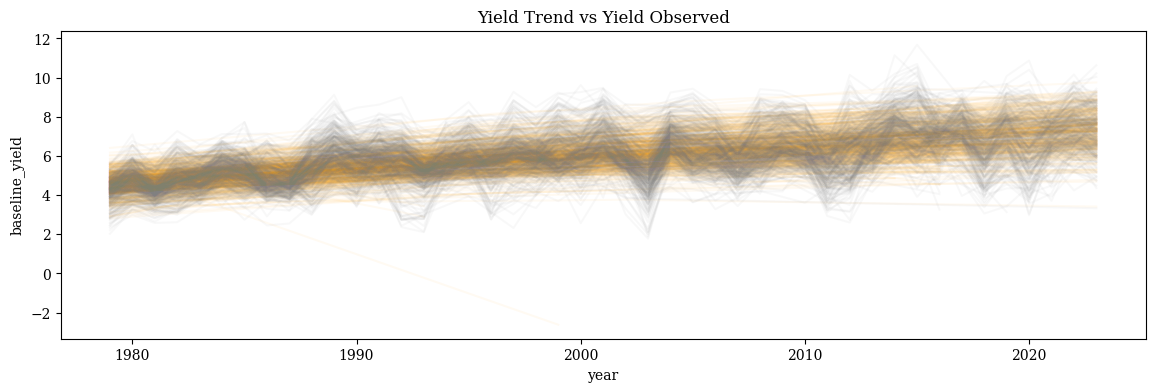

In [92]:
# Plot yield trend vs actual yield
plt.figure(figsize=(14, 4))
sns.lineplot(
    data=baseline_df,
    x="year",
    y="baseline_yield",
    estimator=None,
    units="NUTS_ID",
    color="orange",
    legend=True,
    alpha=0.05,
)

sns.lineplot(
    data=baseline_df,
    x="year",
    y="yield",
    estimator=None,
    units="NUTS_ID",
    color="grey",
    legend=True,
    alpha=0.05,
)

plt.title("Yield Trend vs Yield Observed")
plt.savefig(
    os.path.join(output_dir, "yield_trend_vs_yield_observed.png"),
    format="png",
    bbox_inches="tight",
)
plt.show()

#### Plot Mean and Std of Observed and Detrended Yield


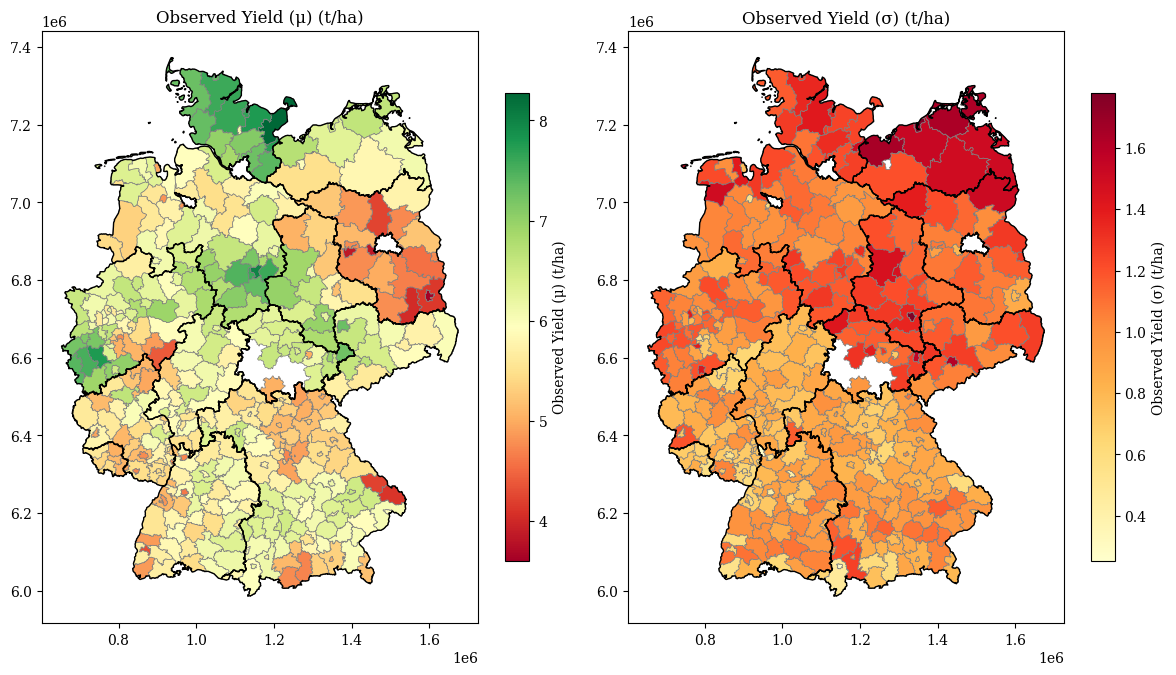

In [93]:
# Plot the mean and standard deviation map
nuts3_info = pd.merge(
    left=nuts3_info,
    right=yield_anomaly[
        ["NUTS_ID", "mean_yield", "std_yield", "mean_detrended", "std_detrended"]
    ].drop_duplicates(),
    on=["NUTS_ID"],
    how="left",
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes = axes.flatten()

nuts3_info.plot(
    ax=axes[0],
    column="mean_yield",
    cmap="RdYlGn",
    edgecolor="grey",
    linewidth=0.5,
    label="Mean Yield",
    legend=True,
    legend_kwds={"shrink": 0.7, "label": "Observed Yield (μ) (t/ha)"},
)
de_nuts1_gdf.plot(
    ax=axes[0], facecolor="none", edgecolor="k", linewidth=1, label="NUTS1"
)

nuts3_info.plot(
    ax=axes[1],
    column="std_yield",
    cmap="YlOrRd",
    edgecolor="grey",
    linewidth=0.5,
    label="Std Yield",
    legend=True,
    legend_kwds={"shrink": 0.7, "label": "Observed Yield (σ) (t/ha)"},
)
de_nuts1_gdf.plot(
    ax=axes[1], facecolor="none", edgecolor="k", linewidth=1, label="NUTS1"
)

axes[0].set_title("Observed Yield (μ) (t/ha)")
axes[1].set_title("Observed Yield (σ) (t/ha)")

plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, "yield_mean_and_std.png"),
    format="png",
    bbox_inches="tight",
)
plt.show()

#### Plot Yearly Anomaly Map of Observed and Detrended Yield


  0%|          | 0/45 [00:00<?, ?it/s]

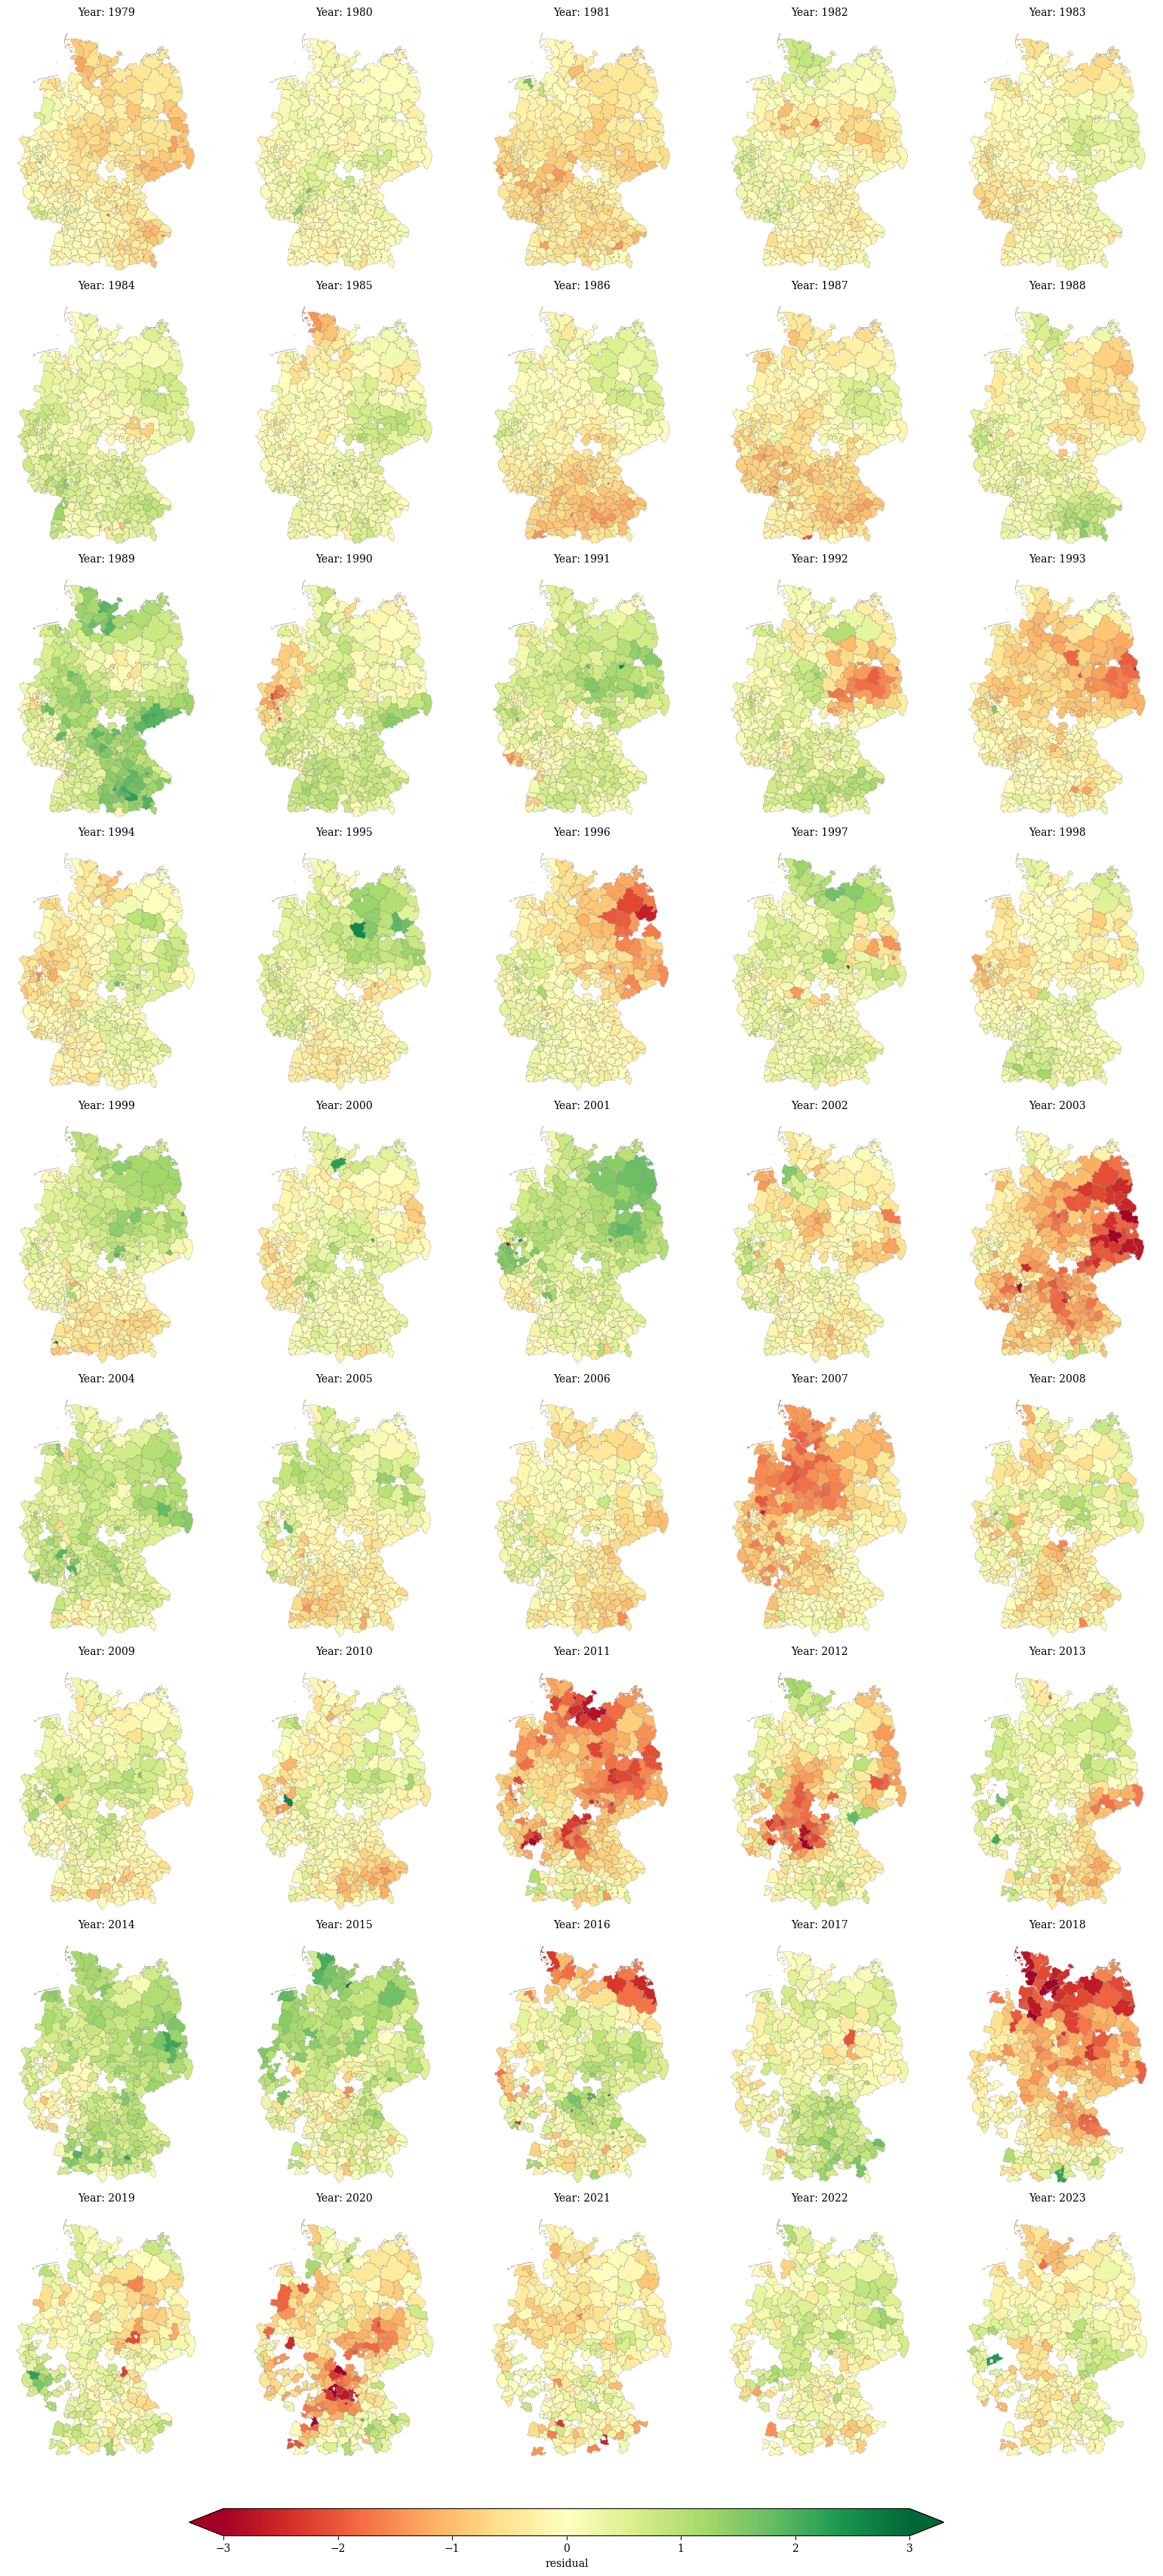

In [94]:
years = sorted(yield_anomaly["year"].unique())

ncols = 5
nrows = (len(years) + ncols - 1) // ncols  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
axes = axes.flatten()

var = "residual"
vmin, vmax = -3, 3
cmap = "RdYlGn"

for i, year in tqdm(enumerate(years), total=len(years)):
    anomaly_df = yield_anomaly[yield_anomaly["year"] == year][["NUTS_ID", "year", var]]
    anomaly_gdf = pd.merge(
        left=nuts3_info[["NUTS_ID", "geometry"]],
        right=anomaly_df,
        on="NUTS_ID",
        how="left",
    )

    # plot
    anomaly_gdf.plot(
        ax=axes[i],
        column=var,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        edgecolor="grey",
        linewidth=0.2,
    )
    axes[i].set_title(f"Year: {year}", fontsize=10)
    axes[i].axis("off")

# remove extra empty axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# add a single colorbar
cax = fig.add_axes([0.15, 0.025, 0.5, 0.01])  # [left, bottom, width, height]
norm = Normalize(vmin=vmin, vmax=vmax)
cb = ColorbarBase(
    cax, cmap=plt.get_cmap(cmap), norm=norm, orientation="horizontal", extend="both"
)
cb.set_label(var)

fig.subplots_adjust(
    left=0.02, right=0.80, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05
)
plt.savefig(
    os.path.join(output_dir, f"yearly_{var}.png"), format="png", bbox_inches="tight"
)
plt.show()

#### Plot Long-term Timeseries of Observed and Detrended Yield


In [95]:
# Define threshold
threshold = 2

# Identify extremes
yield_anomaly["pos_extreme"] = yield_anomaly["z_anomaly"].where(
    yield_anomaly["z_anomaly"] > threshold
)
yield_anomaly["neg_extreme"] = yield_anomaly["z_anomaly"].where(
    yield_anomaly["z_anomaly"] < -threshold
)

yield_anomaly["pos_extreme_detrended"] = yield_anomaly["z_anomaly_detrended"].where(
    yield_anomaly["z_anomaly_detrended"] > threshold
)
yield_anomaly["neg_extreme_detrended"] = yield_anomaly["z_anomaly_detrended"].where(
    yield_anomaly["z_anomaly_detrended"] < -threshold
)

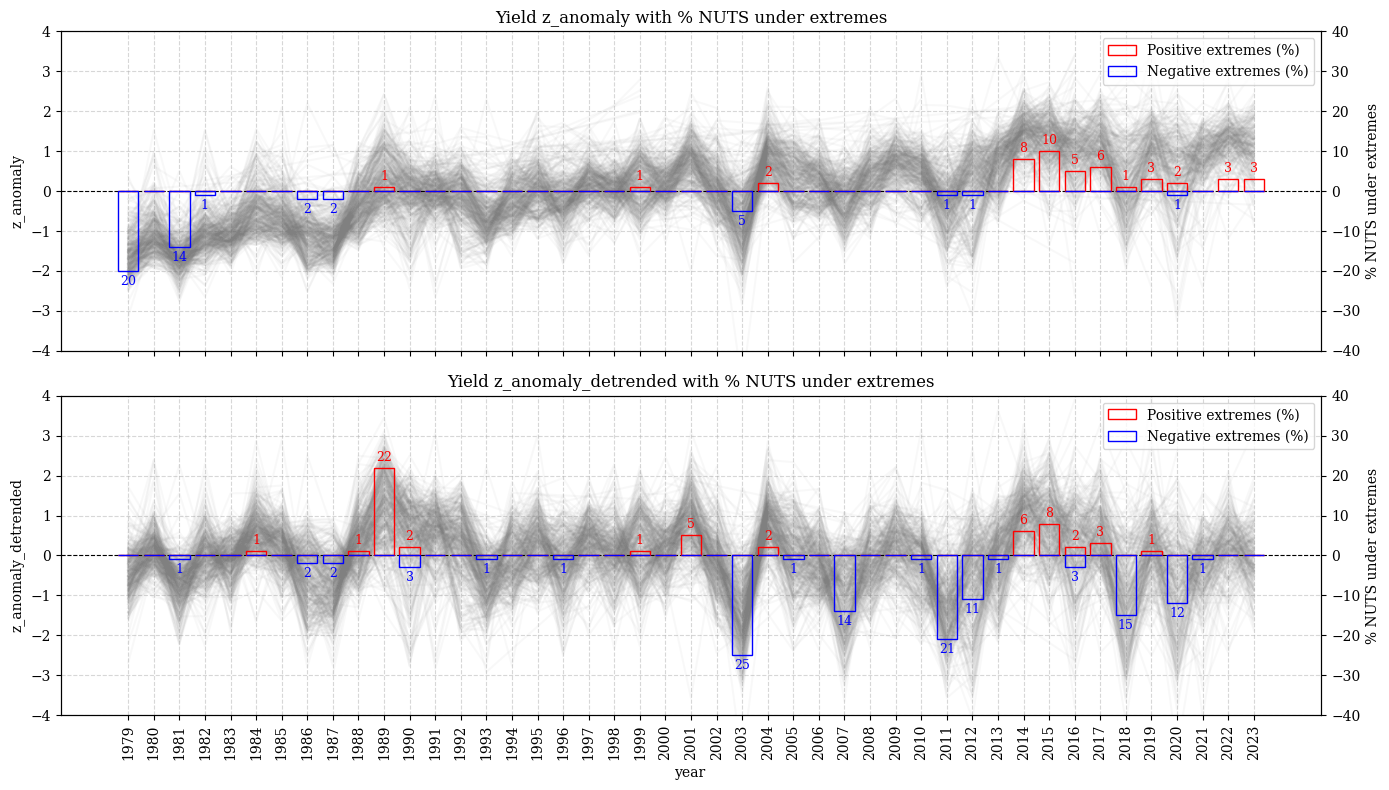

In [97]:
df_grouped = yield_anomaly.groupby("year").mean(numeric_only=True).reset_index()
df_grouped = df_grouped.sort_values("year")

df_perc = (
    yield_anomaly.groupby("year")
    .agg(
        perc_pos_extreme=("pos_extreme", lambda x: x.notna().sum()),
        perc_neg_extreme=("neg_extreme", lambda x: x.notna().sum()),
        perc_pos_extreme_detrended=("pos_extreme_detrended", lambda x: x.notna().sum()),
        perc_neg_extreme_detrended=("neg_extreme_detrended", lambda x: x.notna().sum()),
    )
    .reset_index()
)
df_perc.iloc[:, 1:] = ((df_perc.iloc[:, 1:] / len(nuts3_info)) * 100).astype("int")

df_grouped = df_grouped.merge(df_perc, on="year")

years = np.arange(df_grouped["year"].min(), df_grouped["year"].max() + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)
axes = axes.flatten()

### TOP PLOT ###
# plot z_anomaly line on left axis
sns.lineplot(
    data=yield_anomaly,
    x="year",
    y="z_anomaly",
    estimator=None,
    units="NUTS_ID",
    color="grey",
    legend=False,
    alpha=0.05,
    ax=axes[0],
)

# add secondary y-axis for % extremes
ax2_0 = axes[0].twinx()

# plot percentage of extremes as bars on right axis
ax2_0.bar(
    df_grouped["year"],
    df_grouped["perc_pos_extreme"],
    color="none",
    edgecolor="red",
    alpha=1,
    width=0.8,
    label="Positive extremes (%)",
)
ax2_0.bar(
    df_grouped["year"],
    -df_grouped["perc_neg_extreme"],  # negative so bars go downward
    color="none",
    edgecolor="blue",
    alpha=1,
    width=0.8,
    label="Negative extremes (%)",
)

### TOP PLOT annotations ###
for i, row in df_grouped.iterrows():
    x = row["year"]
    # positive bar
    if row["perc_pos_extreme"] > 0:
        ax2_0.text(
            x,
            row["perc_pos_extreme"] + 1,  # small offset above the bar
            str(int(round(row["perc_pos_extreme"]))),
            ha="center",
            va="bottom",
            fontsize=9,
            color="red",
        )
    # negative bar
    if row["perc_neg_extreme"] > 0:
        ax2_0.text(
            x,
            -row["perc_neg_extreme"] - 1,  # small offset below the bar
            str(int(round(row["perc_neg_extreme"]))),
            ha="center",
            va="top",
            fontsize=9,
            color="blue",
        )

# add horizontal line at 0
axes[0].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[0].set_title("Yield z_anomaly with % NUTS under extremes")
axes[0].grid(True, linestyle="--", alpha=0.5)

ax2_0.set_ylabel("% NUTS under extremes")
ax2_0.legend(loc="upper right")

axes[0].set_ylim(-4, 4)  # left y-axis: z_anomaly
ax2_0.set_ylim(-40, 40)

### BOTTOM PLOT ###
# plot z_anomaly_detrended line on left axis
sns.lineplot(
    data=yield_anomaly,
    x="year",
    y="z_anomaly_detrended",
    estimator=None,
    units="NUTS_ID",
    color="grey",
    legend=False,
    alpha=0.05,
    ax=axes[1],
)

# add secondary y-axis
ax2_1 = axes[1].twinx()

# plot percentage of extremes as bars
ax2_1.bar(
    df_grouped["year"],
    df_grouped["perc_pos_extreme_detrended"],
    color="none",
    edgecolor="red",
    alpha=1,
    width=0.8,
    label="Positive extremes (%)",
)
ax2_1.bar(
    df_grouped["year"],
    -df_grouped["perc_neg_extreme_detrended"],
    color="none",
    edgecolor="blue",
    alpha=1,
    width=0.8,
    label="Negative extremes (%)",
)

### BOTTOM PLOT annotations ###
for i, row in df_grouped.iterrows():
    x = row["year"]
    if row["perc_pos_extreme_detrended"] > 0:
        ax2_1.text(
            x,
            row["perc_pos_extreme_detrended"] + 1,
            str(int(round(row["perc_pos_extreme_detrended"]))),
            ha="center",
            va="bottom",
            fontsize=9,
            color="red",
        )
    if row["perc_neg_extreme_detrended"] > 0:
        ax2_1.text(
            x,
            -row["perc_neg_extreme_detrended"] - 1,
            str(int(round(row["perc_neg_extreme_detrended"]))),
            ha="center",
            va="top",
            fontsize=9,
            color="blue",
        )

axes[1].axhline(0, color="black", linewidth=0.8, linestyle="--")
axes[1].set_title("Yield z_anomaly_detrended with % NUTS under extremes")
axes[1].grid(True, linestyle="--", alpha=0.5)

ax2_1.set_ylabel("% NUTS under extremes")
ax2_1.legend(loc="upper right")

# shared x-axis
axes[1].set_xticks(years)
axes[1].set_xticklabels(years, rotation=90)

axes[1].set_ylim(-4, 4)
ax2_1.set_ylim(-40, 40)

plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, f"yield_timeseries_with_pos_neg_extremes.png"),
    format="png",
    bbox_inches="tight",
)
plt.show()

### Yield Trends per NUTS


In [98]:
# Get list of unique districts
nuts = baseline_df["NUTS_ID"].unique()

# Create a dataframe to store slopes & p-values
trend_results = []

# Loop through each district
for i in nuts:
    df_nuts = baseline_df[baseline_df["NUTS_ID"] == i].sort_values("year")

    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(
        df_nuts["year"], df_nuts["yield"]
    )

    trend_results.append(
        {"NUTS_ID": i, "slope": slope, "r_squared": r_value**2, "p_value": p_value}
    )

# Convert results to dataframe
trend_df = pd.DataFrame(trend_results)

# Show the trend table
print(trend_df.shape)
trend_df.head()

(397, 4)


NUTS_ID     slope  r_squared       p_value
0   DE111  0.028089   0.128752  9.268516e-02
1   DE112  0.039805   0.256493  5.297706e-04
2   DE113  0.042520   0.510894  5.035288e-08
3   DE114  0.072808   0.791001  3.267050e-16
4   DE115  0.050791   0.595115  5.580449e-10

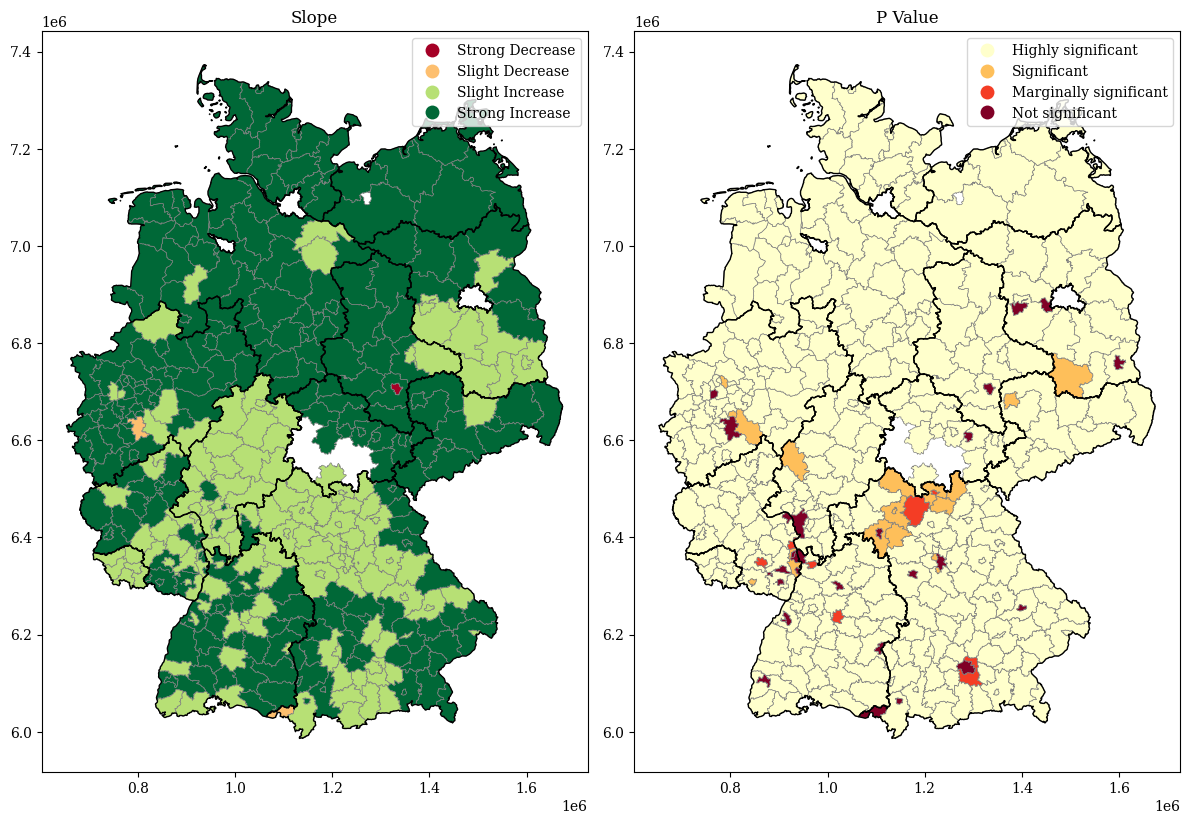

In [ ]:
# Plot the mean and standard deviation map
nuts3_info = pd.merge(left=nuts3_info, right=trend_df, on=["NUTS_ID"], how="left")

slope_bins = [-float("inf"), -0.05, 0, 0.05, float("inf")]
slope_labels = [
    "Strong Decrease",
    "Slight Decrease",
    "Slight Increase",
    "Strong Increase",
]

nuts3_info["slope_category"] = pd.cut(
    nuts3_info["slope"], bins=slope_bins, labels=slope_labels
)

# P-value bins & categories
pvalue_bins = [-float("inf"), 0.01, 0.05, 0.1, float("inf")]
pvalue_labels = [
    "Highly significant",
    "Significant",
    "Marginally significant",
    "Not significant",
]

nuts3_info["pvalue_category"] = pd.cut(
    nuts3_info["p_value"], bins=pvalue_bins, labels=pvalue_labels
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axes = axes.flatten()

nuts3_info.plot(
    ax=axes[0],
    column="slope_category",
    cmap="RdYlGn",
    edgecolor="grey",
    linewidth=0.5,
    legend=True,
)
de_nuts1_gdf.plot(
    ax=axes[0], facecolor="none", edgecolor="k", linewidth=1, label="NUTS1"
)

nuts3_info.plot(
    ax=axes[1],
    column="pvalue_category",
    cmap="YlOrRd",
    edgecolor="grey",
    linewidth=0.5,
    legend=True,
)
de_nuts1_gdf.plot(
    ax=axes[1], facecolor="none", edgecolor="k", linewidth=1, label="NUTS1"
)

axes[0].set_title("Slope")
axes[1].set_title("P Value")

plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, "yield_slope_and_trend.png"),
    format="png",
    bbox_inches="tight",
)
plt.show()